# Classical Music Kaggle Competition

Author: Zach Xing

In [4]:
import pandas as pd
import numpy as np
import re

from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


import xgboost as xgb

### Description
We have received several data files as described below to use in our model. Our training dataset in train.csv contains account IDs of patrons along with a target label (0 or 1) indicating whether they purchased a subscription for the 2014-15 concert season. Our objective is to predict whether the patrons listed in the test.csv file will purchase subscriptions or not. Be sure that your output file matches exactly with the format in the sample_submissions.csv file, including the same column headings. You should submit your "soft predictions" (your probabilistic prediction that they will purchase a subscription), NOT discrete 0/1 predictions, since our scoring metric for this competition is AUROC.



### Data

train.csv - the training set containing target labels indicating whether the patrons have purchased a 2014-15 subscription or not

test.csv - the test set of accounts for which we are to make a prediction

sample_submission.csv - a sample submission file in the correct format

account.csv - location info for each patron and donation history

tickets_all.csv - previously purchased tickets by account

subscriptions.csv - previously purchased subscriptions by account

concerts.csv - previous concerts by season.

concerts_2014-15.csv - list of planned concert sets for the 2014-15 season

zipcodes.csv - location and demographic information for zipcodes

In [5]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

df_account = pd.read_csv('data/account.csv', encoding='latin-1')
df_tickets = pd.read_csv('data/tickets_all.csv')
df_sub = pd.read_csv('data/subscriptions.csv')
df_concerts = pd.read_csv('data/concerts.csv')
df_concerts1415 = pd.read_csv('data/concerts_2014-15.csv')
df_zipcodes = pd.read_csv('data/zipcodes.csv')

Feature 1. Extract the number of perfomers of each that has appeared in the past subscription of each users

In [6]:
# replace \r with , in who column
df_concerts['who'] = df_concerts['who'].str.replace('\r', ',')

In [7]:
def extract_names(s):
    # Regular expression pattern to match two consecutive capitalized words
    pattern = r'\b([A-Z][a-zA-Z]+(?:\s[A-Z][a-zA-Z]+)+)\b'
    return re.findall(pattern, s)

In [8]:
df_concerts1415['extracted_names'] = df_concerts1415['who'].apply(extract_names)
df_concerts['extracted_names'] = df_concerts['who'].apply(extract_names)

names_list_1415 = np.unique([name for sublist in df_concerts1415['extracted_names'].tolist() for name in sublist]).tolist()
names_list_1415

['Adler Fellowship Program Ted Huffman',
 'Andreas Scholl',
 'Brian Thorsett',
 'Bruce Lamott',
 'Christopher Ainslie',
 'Clifton Massey',
 'Dashon Burton',
 'Dominique Labelle',
 'Jeffrey Fields',
 'Julian Wachner',
 'Nicholas McGegan',
 'Rachel Podger',
 'San Francisco Opera',
 'Sherezade Panthaki',
 'Steven Isserlis',
 'The Philharmonia Chorale',
 'Thomas Cooley']

In [9]:
# get all the season of each unique account.id
grouped_season_eachID = df_sub.groupby('account.id')['season'].unique().reset_index()


In [10]:
# Extract all the performers of the past seasons
df_concerts_extract_names = df_concerts.groupby('season')['extracted_names'].sum().reset_index()
df_concerts_extract_names['unique_names'] = df_concerts_extract_names['extracted_names'].apply(lambda x: list(set(x)))
df_concerts_extract_names.drop('extracted_names', axis=1, inplace=True)

In [11]:
# As we only have the data of the past 4 seasons, we will only consider past 4 seasons here
df_sub_10_14 = df_sub[df_sub['season'].isin(['2010-2011', '2011-2012', '2012-2013', '2013-2014'])]
df_sub_10_14 = pd.merge(df_sub_10_14, df_concerts_extract_names, on='season', how='left')

In [12]:
df_sub_10_14

,account.id,season,package,no.seats,location,section,price.level,subscription_tier,multiple.subs,unique_names
0,001i000000LhycQ,2012-2013,Trio A,2,Peninsula,Orchestra,4.0,1.0,no,"[Amy Freston, Helene Zindarsian, Paul Jones, D..."
1,001i000000LhyaV,2012-2013,Trio B,1,Peninsula,Orchestra,1.0,0.5,no,"[Amy Freston, Helene Zindarsian, Paul Jones, D..."
2,001i000000NuQvL,2010-2011,Full,1,Berkeley Saturday,Balcony Front,3.0,1.0,no,"[Bruce Lamott, Music Director, Dominique Label..."
3,001i000000LhyXZ,2013-2014,Trio A,1,Peninsula,NaN,1.0,0.5,no,"[Tanya Tomkins, Diana Moore, Dominique Labelle..."
4,001i000000LhyRY,2010-2011,Full,2,San Francisco,Orchestra,1.0,2.0,no,"[Bruce Lamott, Music Director, Dominique Label..."
...,...,...,...,...,...,...,...,...,...,...
4124,001i000000NuNxH,2013-2014,Trio A,1,San Francisco,NaN,1.0,0.5,no,"[Tanya Tomkins, Diana Moore, Dominique Labelle..."
4125,001i000000NuQ6f,2010-2011,Quartet CC,2,Contra Costa,Orchestra,2.0,1.0,no,"[Bruce Lamott, Music Director, Dominique Label..."
4126,001i000000LhyPW,2012-2013,Full,2,Berkeley Sunday,Orchestra,0.0,2.0,no,"[Amy Freston, Helene Zindarsian, Paul Jones, D..."
4127,001i000000LhyaC,2012-2013,Trio A,1,Berkeley Saturday,Balcony Front,3.0,0.5,no,"[Amy Freston, Helene Zindarsian, Paul Jones, D..."


In [13]:
agg_names = df_sub_10_14.groupby('account.id').apply(
    lambda group: list(set(name for sublist in group['unique_names'] for name in sublist))
).reset_index()

agg_names.columns = ['account.id', 'aggregated_unique_names']

agg_names

,account.id,aggregated_unique_names
0,001i000000LhyPD,"[Amy Freston, Music Director, Helene Zindarsia..."
1,001i000000LhyPE,"[Amy Freston, Music Director, Helene Zindarsia..."
2,001i000000LhyPF,"[Amy Freston, Music Director, Helene Zindarsia..."
3,001i000000LhyPG,"[Amy Freston, Music Director, Helene Zindarsia..."
4,001i000000LhyPH,"[Amy Freston, Music Director, Helene Zindarsia..."
...,...,...
1523,001i000000V23aW,"[Thomas Cooley, Tanya Tomkins, Diana Moore, Do..."
1524,001i000000V24lZ,"[Thomas Cooley, Tanya Tomkins, Diana Moore, Do..."
1525,001i000000V24u1,"[Thomas Cooley, Tanya Tomkins, Diana Moore, Do..."
1526,001i000000V255R,"[Thomas Cooley, Tanya Tomkins, Diana Moore, Do..."


In [14]:
agg_names['count_in_list'] = agg_names['aggregated_unique_names'].apply(
    lambda names: sum([1 for name in names if name in names_list_1415])
)

agg_names_count = agg_names[['account.id', 'count_in_list']]

Feature 2. Perform one-hot encoding to create dummy variables for the top 5 frequent 'price.level','processed_no_seats','multiple.tickets' of each account that has bought tickets in the past

In [15]:
# Transfer 4.0 to 4 in price.level column
df_tickets['price.level'] = df_tickets['price.level'].apply(lambda x: str(x).split('.')[0])


In [16]:
df_tickets_count = df_tickets.groupby(['account.id']).size().reset_index(name='tickets_counts')

In [17]:
# Sort the dataframe by season and extract unique account.id
df_tickets['season'] = df_tickets['season'].apply(lambda x: str(x).split('-')[0])
df_tickets_unique = df_tickets.sort_values('season').drop_duplicates(['account.id'], keep='last')


In [18]:
# Identify top 5 most frequent values
N = 5
no_seats_top_values = df_tickets_unique['no.seats'].value_counts().head(N).index.tolist()
df_tickets_unique['processed_no_seats'] = df_tickets_unique['no.seats'].apply(lambda x: x if x in no_seats_top_values else 'Other')

In [19]:
df_tickets_encode = pd.get_dummies(df_tickets_unique, columns=['price.level','processed_no_seats','multiple.tickets'], prefix=['dummy_priceLevel','dummy_seats','dummy_multiple'])
# drop the columns number in range of 1:6
df_tickets_encode.drop(df_tickets_encode.columns[1:6], inplace=True, axis=1)

Feature 3. Create dummy variables for the top 5 frequent 'shipping.city','relationship' of each account

In [20]:
# Identify top N most frequent values
N = 5
shipping_cities_top_values = df_account['shipping.city'].value_counts().head(N).index.tolist()
relationship_top_values = df_account['relationship'].value_counts().head(N).index.tolist()

# Convert values that are not in the top N to 'Other'
df_account['processed_shipping_cities'] = df_account['shipping.city'].apply(lambda x: x if x in shipping_cities_top_values else 'Other')
df_account['processed_relationship'] = df_account['relationship'].apply(lambda x: x if x in relationship_top_values else 'Other')

# One-hot encode the processed column
df_encoded = pd.get_dummies(df_account, columns=['processed_shipping_cities', 'processed_relationship'],prefix=['dummy_shipping_city', 'dummy_relationship'])

# Calculate the number of subscriptions per account

In [21]:
# Get the number of subscriptions per account
df_sub_counts = df_sub.groupby('account.id').count()

In [22]:
df_sub_counts

,season,package,no.seats,location,section,price.level,subscription_tier,multiple.subs
account.id,,,,,,,,
001i000000LhyPD,12,12,12,12,11,12,12,12
001i000000LhyPE,6,6,6,6,5,6,6,6
001i000000LhyPF,19,19,19,19,15,16,19,19
001i000000LhyPG,16,16,16,16,13,14,16,16
001i000000LhyPH,11,11,11,11,8,9,11,11
...,...,...,...,...,...,...,...,...
001i000000V23aW,1,1,1,1,0,1,1,1
001i000000V24lZ,1,1,1,1,0,1,1,1
001i000000V24u1,1,1,1,1,0,1,1,1


In [23]:
df_all = df_encoded.merge(df_sub_counts, on='account.id', how='left')
encoded_columns = df_encoded.filter(like='dummy_', axis=1).columns.tolist()
df_target = df_all[['account.id', 'amount.donated.2013', 'amount.donated.lifetime', 'season']+encoded_columns].fillna(0)
# df_target = df_all[['account.id', 'amount.donated.2013', 'amount.donated.lifetime', 'season']].fillna(0)
df_target = df_target.merge(df_tickets_count, on='account.id', how='left').fillna(0)
df_target = df_target.merge(agg_names_count, on='account.id', how='left').fillna(0)
# df_target = df_target.merge(df_tickets_encode, on='account.id', how='left').fillna(False)


In [24]:
df_train_1 = df_train.merge(df_target, on='account.id', how='left')

In [25]:
df_train_1

,account.id,label,amount.donated.2013,amount.donated.lifetime,season,dummy_shipping_city_Berkeley,dummy_shipping_city_Oakland,dummy_shipping_city_Other,dummy_shipping_city_Palo Alto,dummy_shipping_city_San Francisco,dummy_shipping_city_Walnut Creek,dummy_relationship_Education Participant,dummy_relationship_Other,dummy_relationship_Peer Organization,dummy_relationship_Vendor - Artistic,dummy_relationship_Vendor - General,dummy_relationship_Vendor - Marketing,tickets_counts,count_in_list
0,001i000000NuRo3,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
1,001i000000NuRxd,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
2,001i000000NuQGN,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
3,001i000000NuPfL,0,0.0,0.0,1.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
4,001i000000NuQkP,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6936,001i000000NuOqz,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
6937,001i000000NuQXQ,0,0.0,0.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
6938,001i000000NuSoR,0,0.0,18000.0,0.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0
6939,001i000000NuO7r,0,0.0,246.0,8.0,False,False,True,False,False,False,False,True,False,False,False,False,0.0,0.0


In [26]:
df_train_1.drop(['account.id'], inplace=True, axis=1)

In [27]:
X = df_train_1.loc[:, df_train_1.columns != 'label']
y = df_train_1['label']

In [28]:
# split the train data into train and validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=18)

In [29]:
# # create a linear regression model
# logreg = linear_model.LogisticRegression(C=1e5)
# # train the model
# logreg.fit(X_train, y_train)
# # predict on the validation data, use "soft predictions" (your probabilistic prediction)
# y_pred = logreg.predict_proba(X_val)[:, 1]

# # calculate the auroc
# roc_auc_score(y_val, y_pred)


### XGBoost

In [30]:


# Convert data into DMatrix format for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)

# Define the XGBoost parameters
param = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc'
}

# Train the XGBoost model
bst = xgb.train(param, dtrain)

# Predict on the validation data
dval = xgb.DMatrix(X_val)
y_pred = bst.predict(dval)

# Calculate the AUROC
auroc = roc_auc_score(y_val, y_pred)
print(f"AUROC: {auroc:.4f}")

AUROC: 0.9610


### Random Forest Feature Importance

In [31]:
from sklearn.ensemble import RandomForestClassifier


In [32]:
def calc_feature_importances(model,feat_names,num_to_show):
    # Determine the relative importance of each feature using the random forest model
    importances = model.feature_importances_
    # Get an array of the indices that would sort "importances" in reverse order to get largest to smallest
    indices = np.argsort(importances)[::-1]
    ranked_feats = []
    for i in range(len(indices)):
        feat_name = feat_names[indices[i]]
        ranked_feats.append(feat_name)
    RF_ranking = pd.DataFrame()
    RF_ranking['Feat Index'] = indices
    RF_ranking['Feature'] = ranked_feats
    RF_ranking['Importance'] = np.sort(importances)[::-1]
    display(RF_ranking.iloc[:num_to_show,:])

    # Plot the importance value for each feature
    RF_ranking[:num_to_show][::-1].plot(x='Feature',y='Importance',kind='barh',figsize=(12,7),legend=False,title='RF Feature Importance')
    plt.show()
    return RF_ranking

,Feat Index,Feature,Importance
0,16,count_in_list,4.557777e-01
1,2,season,1.798808e-01
2,1,amount.donated.lifetime,1.740427e-01
3,0,amount.donated.2013,1.551856e-01
4,15,tickets_counts,3.077118e-02
5,4,dummy_shipping_city_Oakland,1.759219e-03
6,7,dummy_shipping_city_San Francisco,9.902401e-04
7,5,dummy_shipping_city_Other,8.920723e-04
8,10,dummy_relationship_Other,3.933298e-04
9,9,dummy_relationship_Education Participant,1.840716e-04


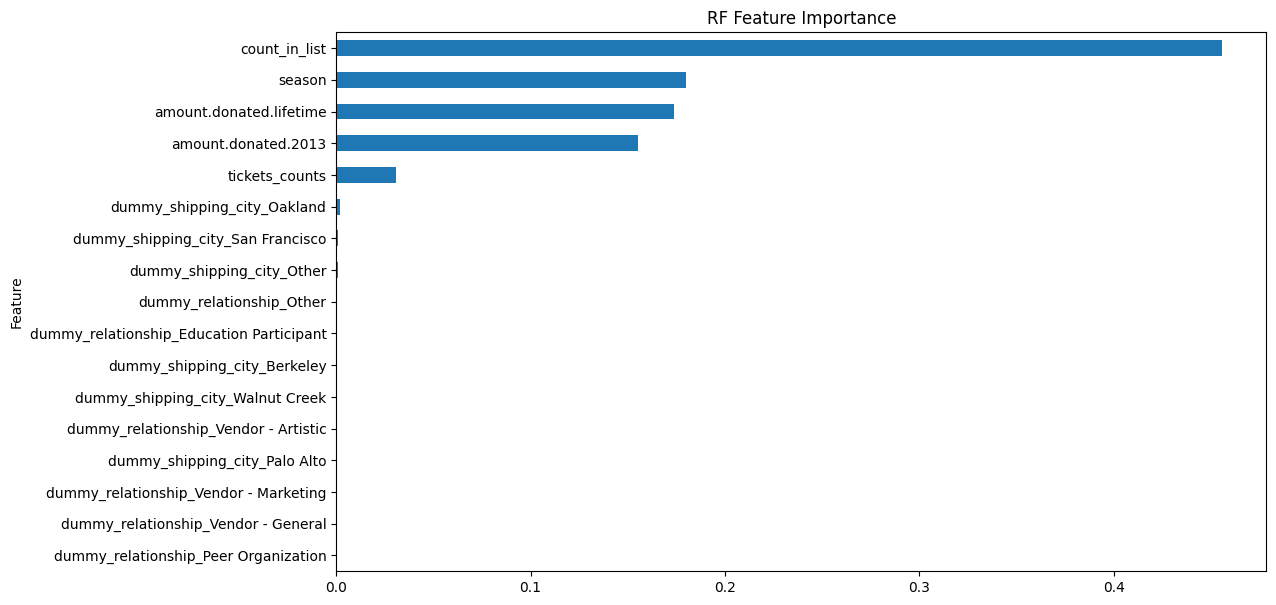

In [33]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)
top_feats = 30
ranking = calc_feature_importances(rf_model,X.columns,top_feats)

### Neural Network

In [34]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from torchvision import datasets, transforms
import torchvision
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [35]:
def prep_dataloaders(X_train,y_train,X_test,y_test,batch_size):
    # Convert training and test data to TensorDatasets
    trainset = TensorDataset(torch.from_numpy(np.array(X_train).astype('float32')), 
                            torch.from_numpy(np.array(y_train).astype('float32')).view(-1,1))
    testset = TensorDataset(torch.from_numpy(np.array(X_test).astype('float32')), 
                            torch.from_numpy(np.array(y_test).astype('float32')).view(-1,1))

    # Create Dataloaders for our training and test data to allow us to iterate over minibatches 
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)

    return trainloader, testloader

batchsize = 32
trainloader,testloader = prep_dataloaders(X_train,y_train,X_val,y_val,batchsize)

In [36]:
class RegressionNet(nn.Module):
    def __init__(self, n_hidden1, n_hidden2):
        super().__init__()
        self.hidden1 = nn.Linear(X_train.shape[1], n_hidden1)
        self.hidden2 = nn.Linear(n_hidden1, n_hidden2)
        self.out = nn.Linear(n_hidden2, 1)

    def forward(self, x):
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = torch.sigmoid(self.out(x))
        return x

# Instantiate our neural network
net = RegressionNet(n_hidden1=50, n_hidden2=5)

In [37]:
# Define our loss function for classification, Binary Cross Entropy
criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [38]:
def train_model(model,criterion,optimizer,trainloader,num_iter,device):
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    cost = []
    for epoch in range(num_iter):

        running_loss = 0.0

        for i, data in enumerate(trainloader):

            # Get the inputs X and labels y for the minibatch
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the gradients of the weights each iteration
            optimizer.zero_grad()

            # Calculate the predictions and the cost/loss
            outputs = model.forward(inputs)
            loss = criterion(outputs, labels)

            # Use autograd to calculate the gradient of the cost with respect to each weight
            loss.backward()

            # Use the optimizer to do the weights update
            optimizer.step()

            # Add the loss to running loss for the epoch
            running_loss += loss.item()

        cost.append(running_loss)
    return cost

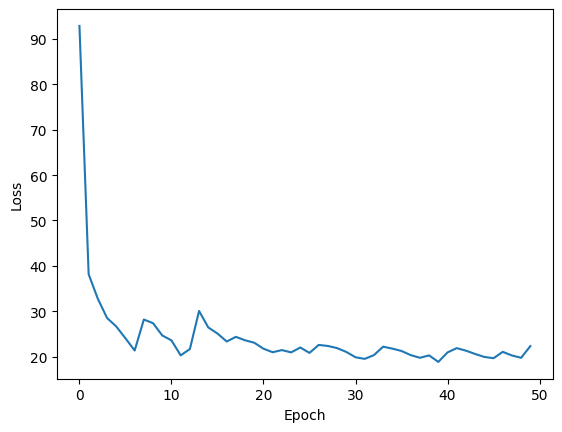

In [39]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Number of iterations (epochs) to train
n_iter = 50

cost_path = train_model(net,criterion,optimizer,trainloader,n_iter,device)

plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [40]:
def test_model(model,test_loader):
    # Turn autograd off
    with torch.no_grad(): 
        # Set the model to evaluation mode
        model = model.to(device)
        model.eval()
        test_preds = []
        # Calculate the predictions on the test set and add to list
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)
            outputs = model.forward(inputs)
            test_preds.extend(outputs.cpu().squeeze().tolist())

    return test_preds

testpreds = test_model(net,testloader)
test_auroc = roc_auc_score(y_val, testpreds)
print(f"AUROC: {test_auroc:.4f}")

AUROC: 0.8598


### Predictions

In [41]:
# reset the column 'ID' to 'account.id'
df_test = df_test.rename(columns={'ID': 'account.id'})
# predict on the test data

df_test_1 = df_test.merge(df_target, on='account.id', how='left')
X_test = df_test_1.loc[:, df_test_1.columns != 'account.id']

dval_test = xgb.DMatrix(X_test)
df_test_1['label'] = bst.predict(dval_test)

# df_test_1['label'] = logreg.predict_proba(df_test_1)[:, 1]
df_test_1 = df_test_1[['account.id', 'label']]
df_test_1 = df_test_1.rename(columns={'account.id': 'ID', 'label': 'Predicted'})


In [42]:
df_test_1

,ID,Predicted
0,001i000000NuQ6Y,0.043528
1,001i000000NuQXz,0.179851
2,001i000000NuRDC,0.023678
3,001i000000NuQeg,0.014815
4,001i000000NuOQc,0.060994
...,...,...
2970,001i000000NuP3y,0.008563
2971,001i000000NuRib,0.008991
2972,001i000000NuP7J,0.008486
2973,001i000000NuRJd,0.019630


In [43]:
# df_test_1.to_csv('submission_test.csv', index=False)